In [1]:
# Parameters
data_process = "data/processed/xy.pkl"
data_final = "data/final/predictions.pkl"


# imports and loading DataFrame

In [2]:
from src.config import Location

location_config = Location()
data_raw_paths = location_config.data_raw

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime

data_locations = data_raw_paths

# fact table
sessions_df = pd.read_json(data_locations["sessions_path"], lines=True)

# dimension tables
deliveries_df = pd.read_json(data_locations["deliveries_path"], lines=True)
products_df = pd.read_json(data_locations["products_path"], lines=True)
users_df = pd.read_json(data_locations["users_path"], lines=True)

# constant values

In [4]:
MAKE_PLOTS = True
MAKE_PAIRPLOT = True
# from src.TimeDiffConstants import DATE_FORMAT, PRICE_TRESHOLD, WEIGHT_TRESHOLD, NUM_OF_HOURS, SEED
SHOW_ALL_WARNINGS = False
SHOW_ONLY_ONE_WARNING = False

In [5]:
from src.config import ProcessConfig, ModelParams

process_config = ProcessConfig()
model_config = ModelParams()
DATE_FORMAT = process_config.DATE_FORMAT
PRICE_TRESHOLD = process_config.PRICE_TRESHOLD
WEIGHT_TRESHOLD = process_config.WEIGHT_TRESHOLD
NUM_OF_HOURS = model_config.NUM_OF_HOURS
SEED = process_config.SEED

In [6]:
import warnings

if SHOW_ONLY_ONE_WARNING:
    warnings.filterwarnings(action='once')
elif not SHOW_ALL_WARNINGS:
    warnings.filterwarnings('ignore')

# merging all data into one DataFrame and other transformations

## adding a column with time difference in deliveries
adding a column with time difference between `purchase_timestamp` and `delivery_timestamp` in deliveries table

1. Cut microseconds from `delivery_timestamp`, so it will be the same format as `purchase_timestamp`, because there are no microseconds in purchase_timestamp (using "." as a separator).
2. Change columns format to datetime
3. Add time_diff column (as timedelta64 object).
4. Drop rows where `time_diff` is null (which means that `delivery_timestamp` was null).
5. Change type of `time_diff` from timedelta64 to seconds in float.
6. Drop rows where `time_diff` is below 0. THIS STEP IS MADE IN `### without time_diff below 0` section

In [7]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]

## join deliveries with sessions

In [8]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

In [9]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

## join with other tables

In [10]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

# missing data analysis - MCAR, MAR, MNAR

made without outliers but with prices below zero (on copy of df)

NOTE: Histograms on the right side of this section are empty because there is no missing data. In the first version of the data provided by the client some data was missing and that's why missing data analysis had to be made.

In [11]:
missing_data_df = df.copy(deep=False)
missing_data_df["delivery_company_is_missing"] = missing_data_df["delivery_company"].isna()
missing_data_df["user_id_is_missing"] = missing_data_df["user_id"].isna()
missing_data_df["product_id_is_missing"] = missing_data_df["product_id"].isna()

In [12]:
# rejecting outliers for given PRICE_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["weight_kg"] <= WEIGHT_TRESHOLD]

In [13]:
NUM_BINS_MISSING = 50

def compare_histograms_for_missing(input_df1, input_df2, end_of_title1="", end_of_title2=""):
    fig, ax = plt.subplots(4, 2)
    
    def plot_histograms_missing(input_df, plot_column, end_of_title=""):

        def plot_hist_missing(x, y, col_name, num_bins=None):
            if num_bins:
                ax[x, y].hist(input_df[col_name], bins=num_bins)
            else:
                ax[x, y].hist(input_df[col_name])
            ax[x, y].set_title(f"histogram of {col_name}" + end_of_title)
            ax[x, y].set_xlabel(col_name)
            ax[x, y].set_ylabel("# of observations")

        plot_hist_missing(0, plot_column, "time_diff", NUM_BINS_MISSING)
        plot_hist_missing(1, plot_column, "offered_discount", NUM_BINS_MISSING)
        plot_hist_missing(2, plot_column, "price", NUM_BINS_MISSING)
        plot_hist_missing(3, plot_column, "weight_kg", NUM_BINS_MISSING)

    plot_histograms_missing(input_df1, 0, end_of_title1)
    plot_histograms_missing(input_df2, 1, end_of_title2)

    fig.set_size_inches([24, 21])
    plt.show()

## delivery_company missing

In [14]:
no_missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == False]
missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == True]

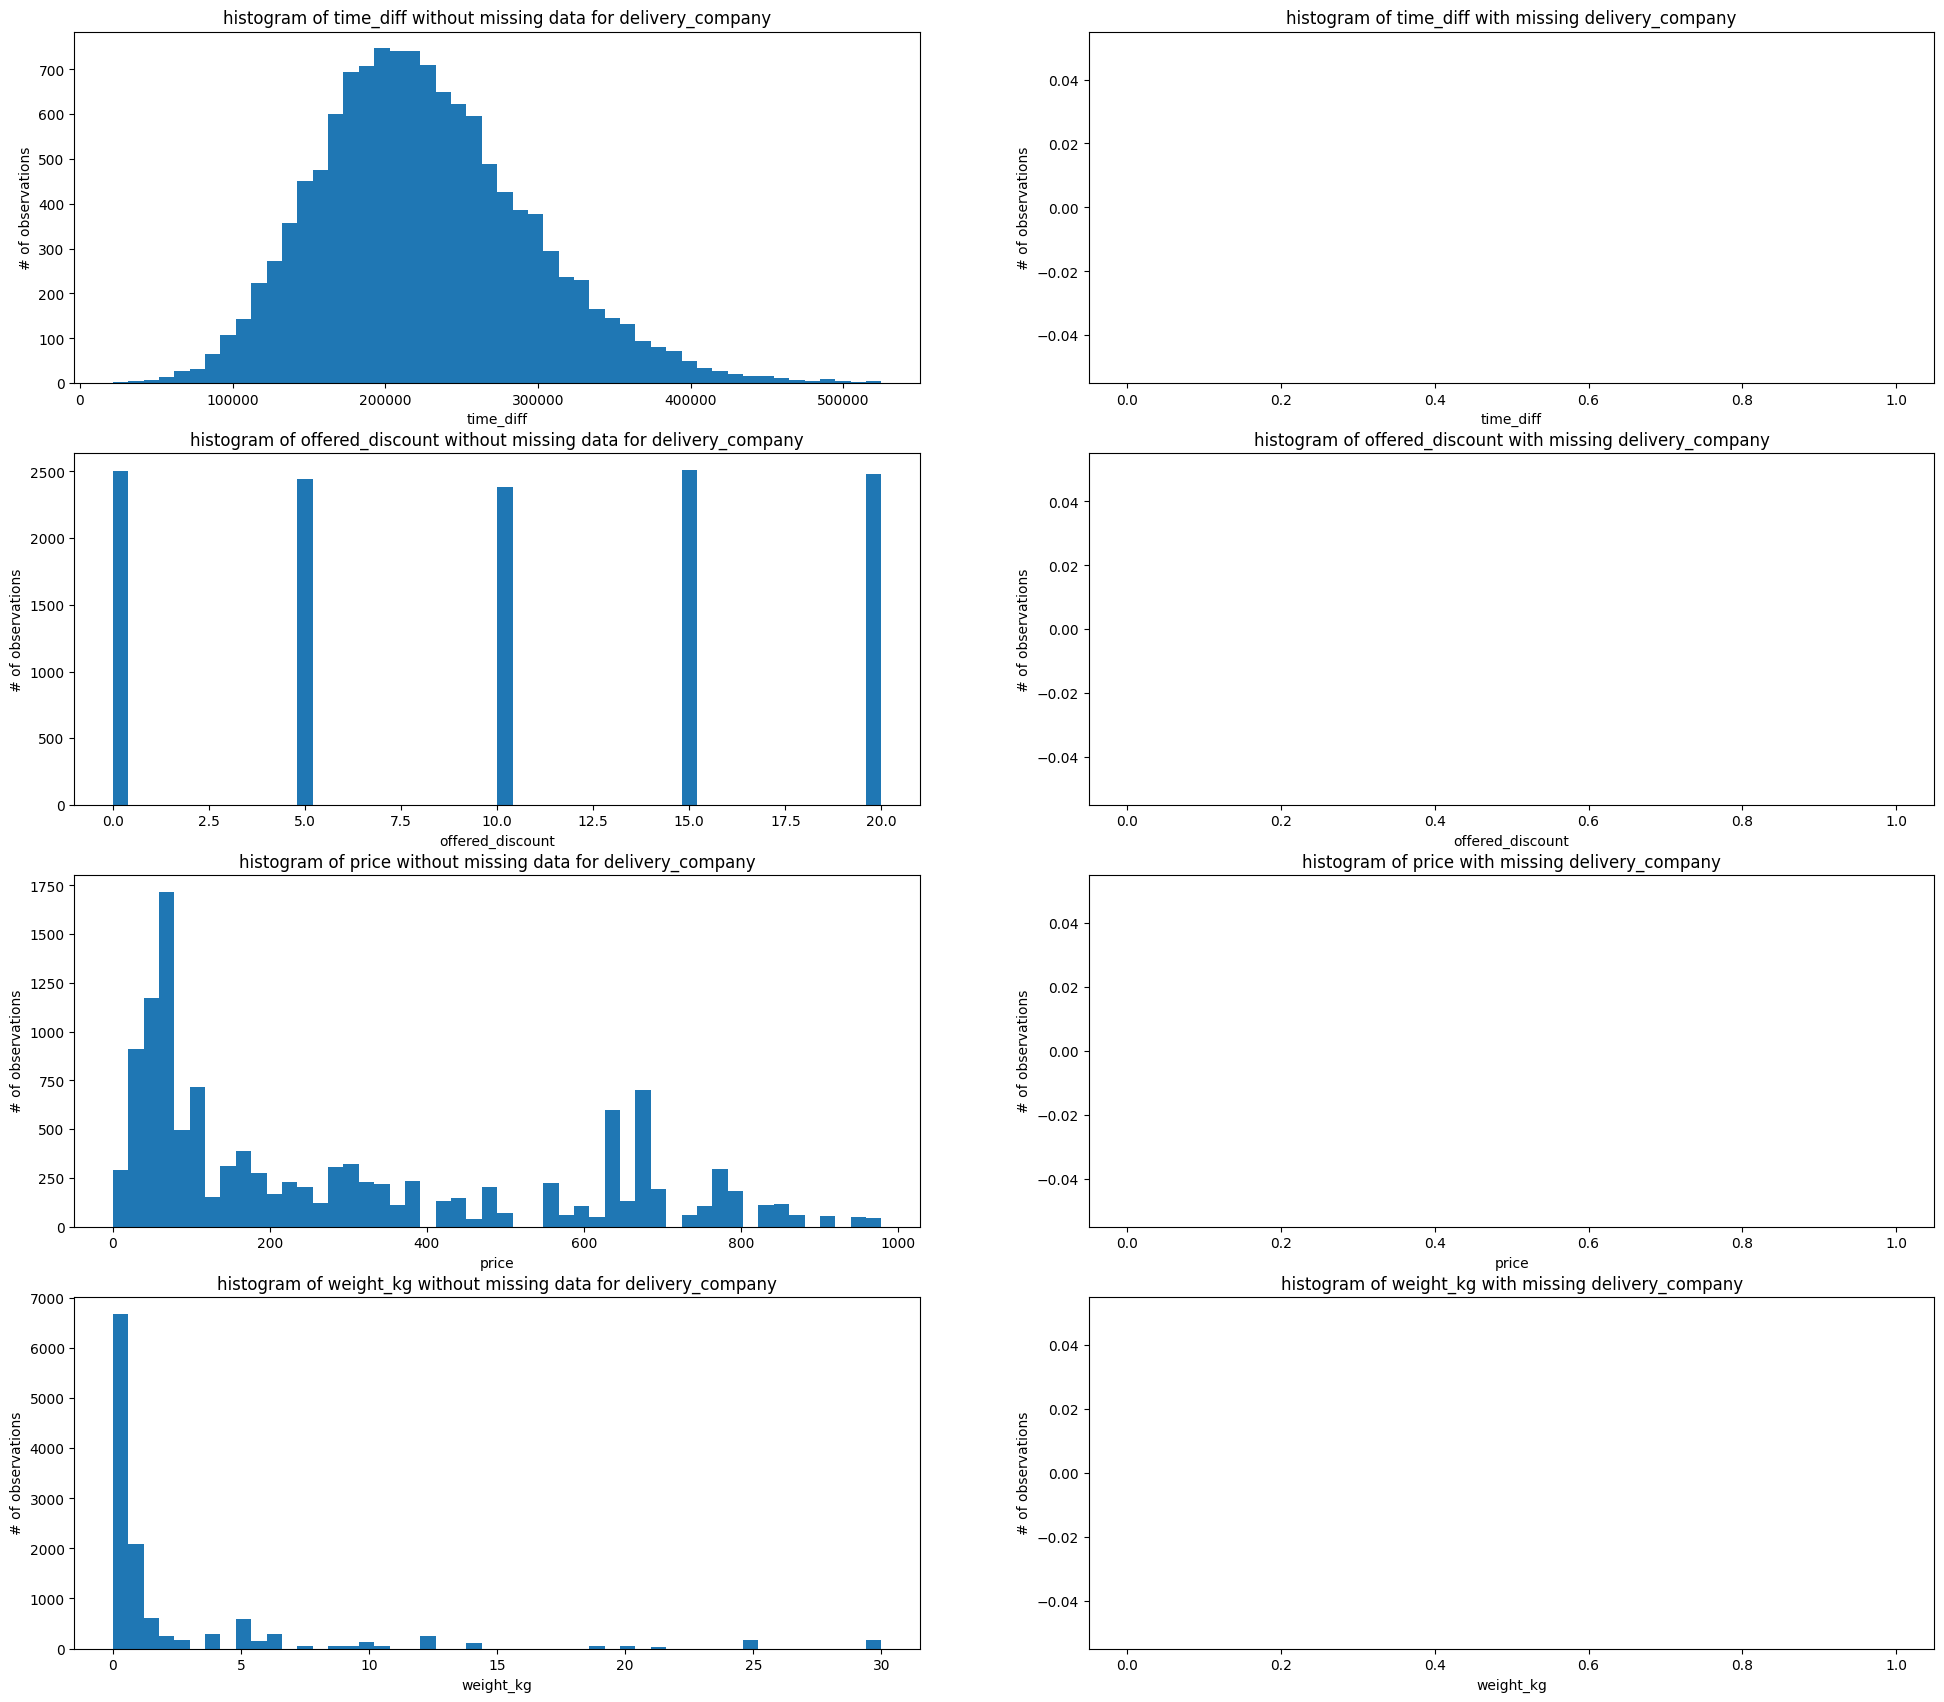

In [15]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_delivery_company, missing_delivery_company, " without missing data for delivery_company", " with missing delivery_company")

## user_id missing

In [16]:
no_missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == False]
missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == True]

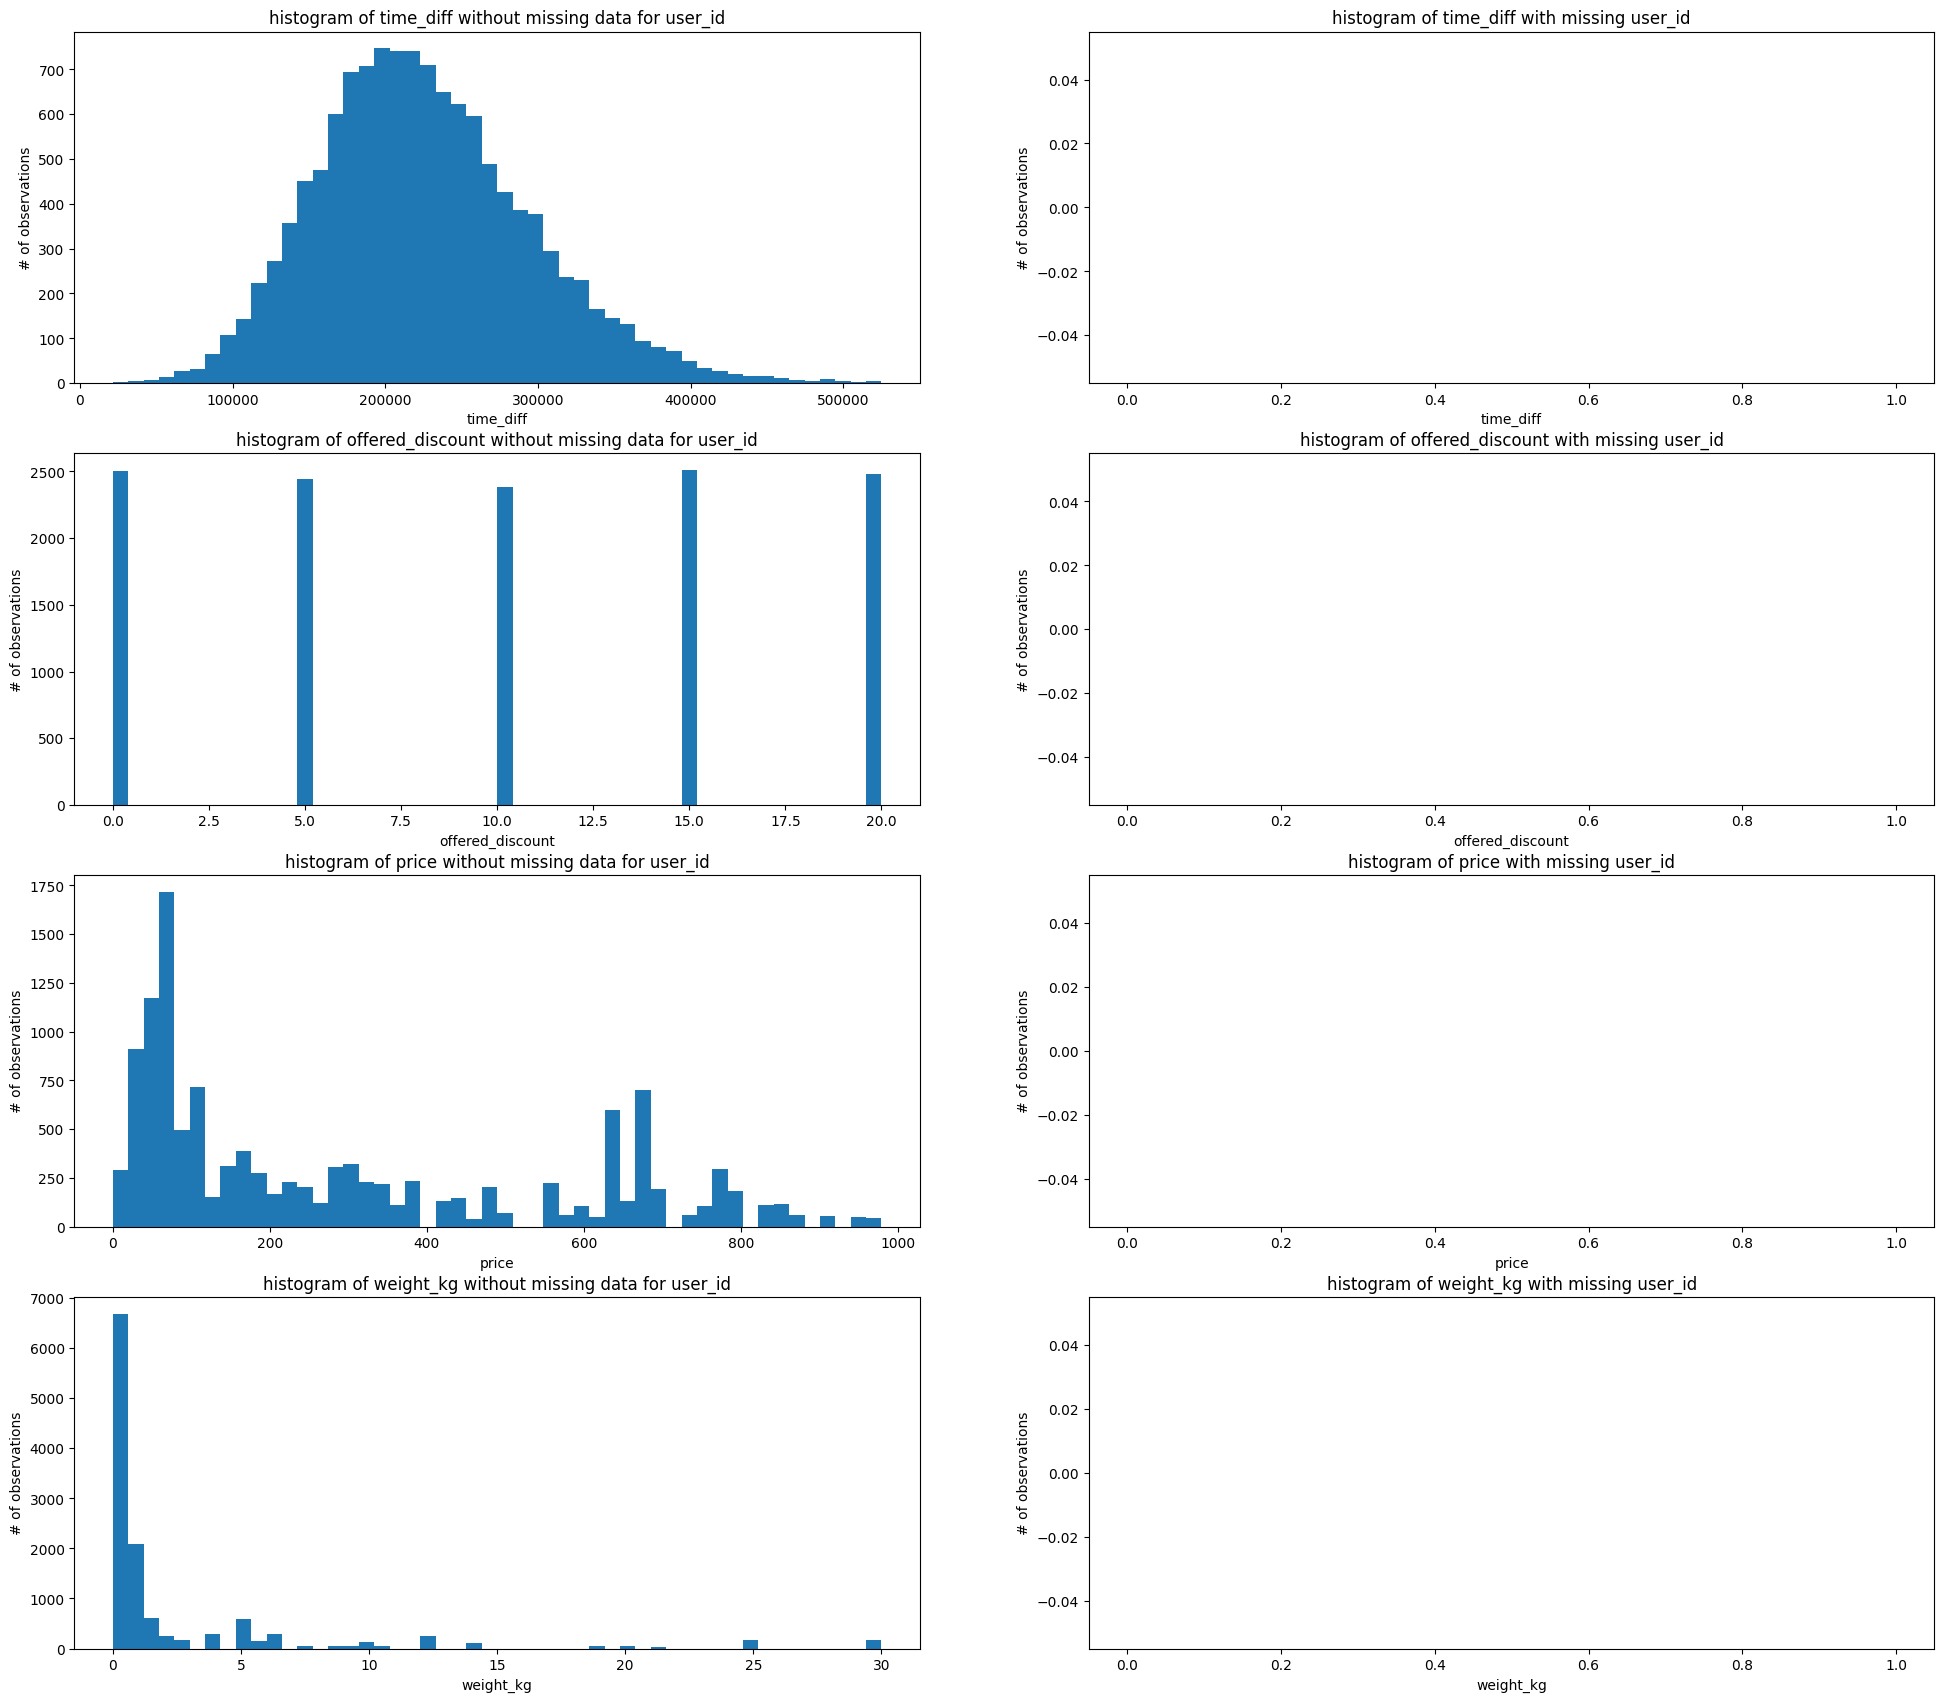

In [17]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_user_id, missing_user_id, " without missing data for user_id", " with missing user_id")

# width, height, depth - normalize optional_attributes

In [18]:
optional_attributes_df = pd.json_normalize(df['optional_attributes'])

In [19]:
display(optional_attributes_df.head())
display(optional_attributes_df.info())
display(optional_attributes_df.describe())

,color,height_cm,width_cm,depth_cm
0,czarny,NaN,NaN,NaN
1,czarny,NaN,NaN,NaN
2,czarny,43.50,16.90,35.60
3,czarny,20.00,23.00,18.20
4,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12428 entries, 0 to 12427
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   color      5708 non-null   object
 1   height_cm  1229 non-null   object
 2   width_cm   1229 non-null   object
 3   depth_cm   1229 non-null   object
dtypes: object(4)
memory usage: 388.5+ KB


None

,color,height_cm,width_cm,depth_cm
count,5708,1229,1229,1229
unique,8,13,15,15
top,czarny,43.50,16.90,35.60
freq,4643,274,274,274


In [20]:
display(optional_attributes_df.nunique())

color         8
height_cm    13
width_cm     15
depth_cm     15
dtype: int64

What we might be interested in are `width_cm`, `height_cm` and `depth_cm` columns. Unfortunately, these attributes occur only about 10% of the time (1116 out of 11452), so they will not be used.

In [21]:
# df[['color', 'width_cm', 'height_cm', 'depth_cm']] = pd.json_normalize(df['optional_attributes'])

# visualizations

## time_diff histogram and log-normal distribution test

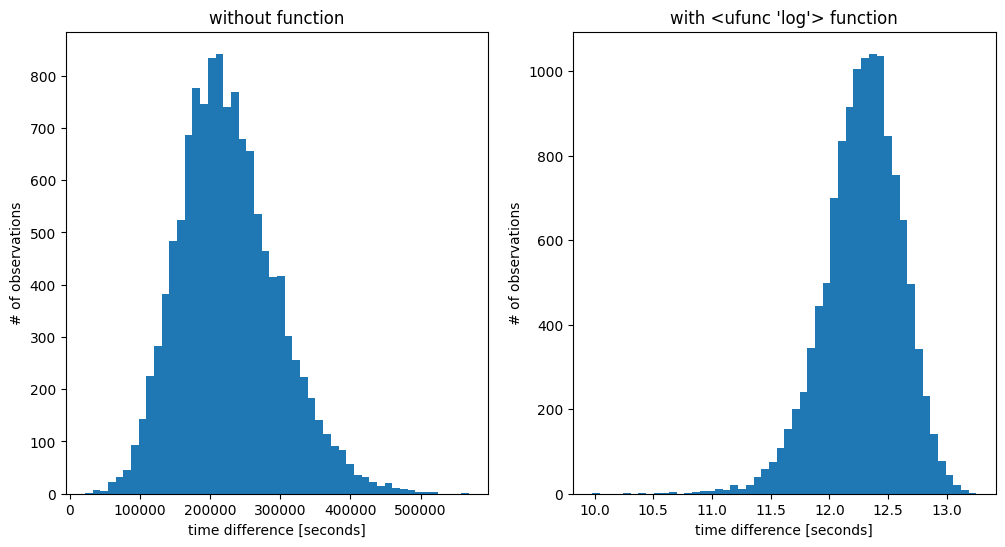

In [22]:
if MAKE_PLOTS:
    fig, ax = plt.subplots(1, 2)

    def plot_hist(x, num_bins=50, func=None):
        if func:
            ax[x].hist(func(df["time_diff"]), bins=num_bins)
            ax[x].set_title(f"with {func} function")
        else:
            ax[x].hist(df["time_diff"], bins=num_bins)
            ax[x].set_title(f"without function")
        ax[x].set_xlabel("time difference [seconds]")
        ax[x].set_ylabel("# of observations")

    plot_hist(0)
    plot_hist(1, func=np.log)
    # plot_hist(1, 0, func=np.log2)
    # plot_hist(1, 1, func=np.log10)

    fig.set_size_inches([12, 6])
    plt.show()

## histograms of continuous variables

In [23]:
NUM_BINS = 50


def plot_histograms(input_df):
    fig, ax = plt.subplots(2, 2)

    def plot_hist(x, y, col_name, num_bins=None):
        if num_bins:
            ax[x, y].hist(input_df[col_name], bins=num_bins)
        else:
            ax[x, y].hist(input_df[col_name])
        ax[x, y].set_title(f"histogram of {col_name}")
        ax[x, y].set_xlabel(col_name)
        ax[x, y].set_ylabel("# of observations")

    plot_hist(0, 0, "time_diff", NUM_BINS)
    plot_hist(0, 1, "offered_discount", NUM_BINS)
    plot_hist(1, 0, "price", NUM_BINS)
    plot_hist(1, 1, "weight_kg", NUM_BINS)

    fig.set_size_inches([12, 12])
    plt.show()

### with outliers

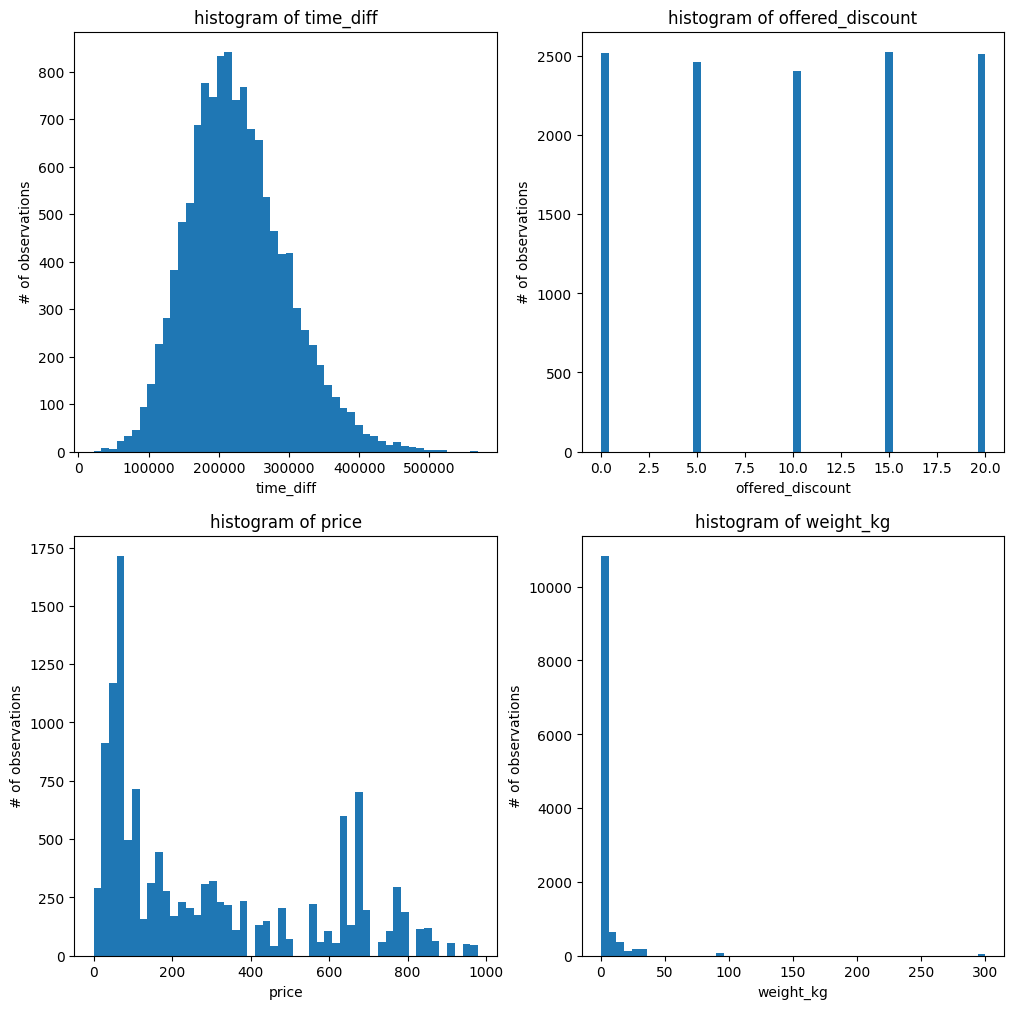

In [24]:
if MAKE_PLOTS:
    plot_histograms(df)

### without outliers

In [25]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

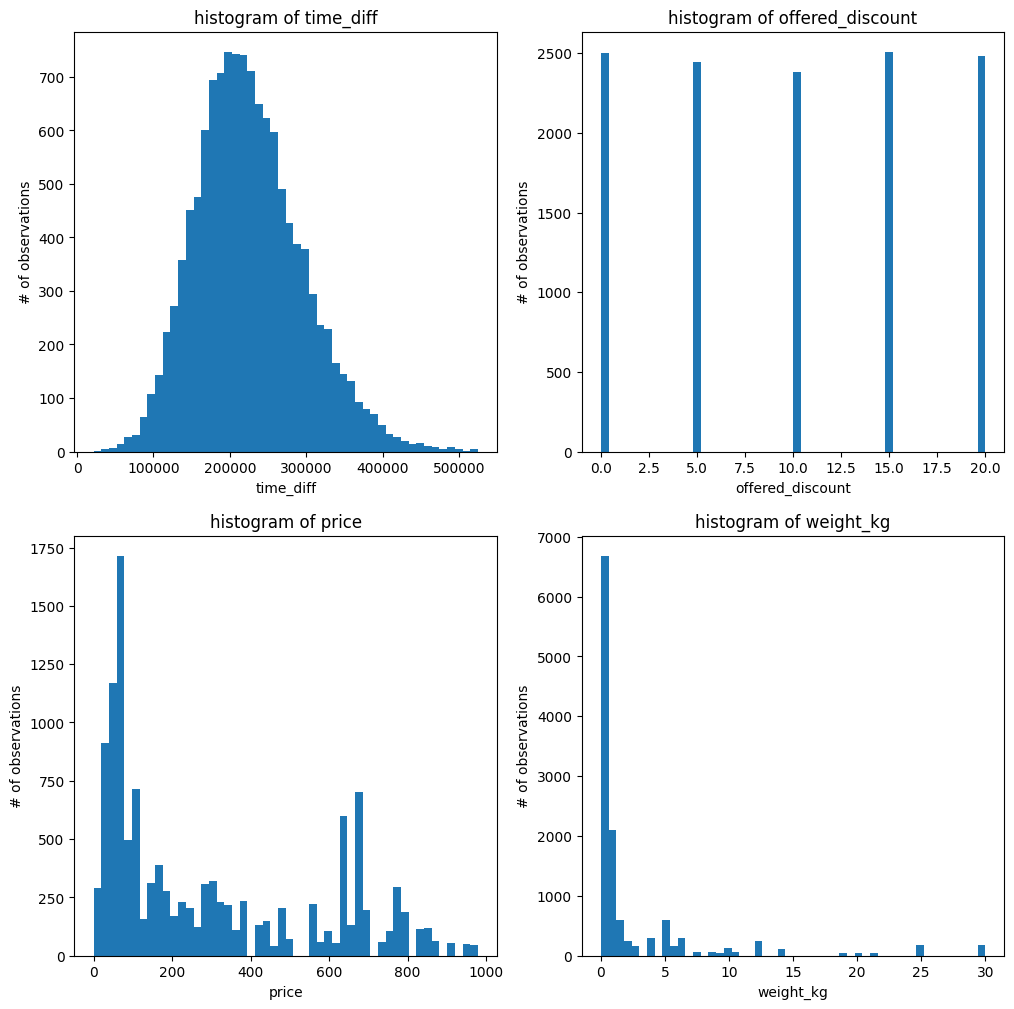

In [26]:
if MAKE_PLOTS:
    plot_histograms(df)

### without prices below 0

In [27]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

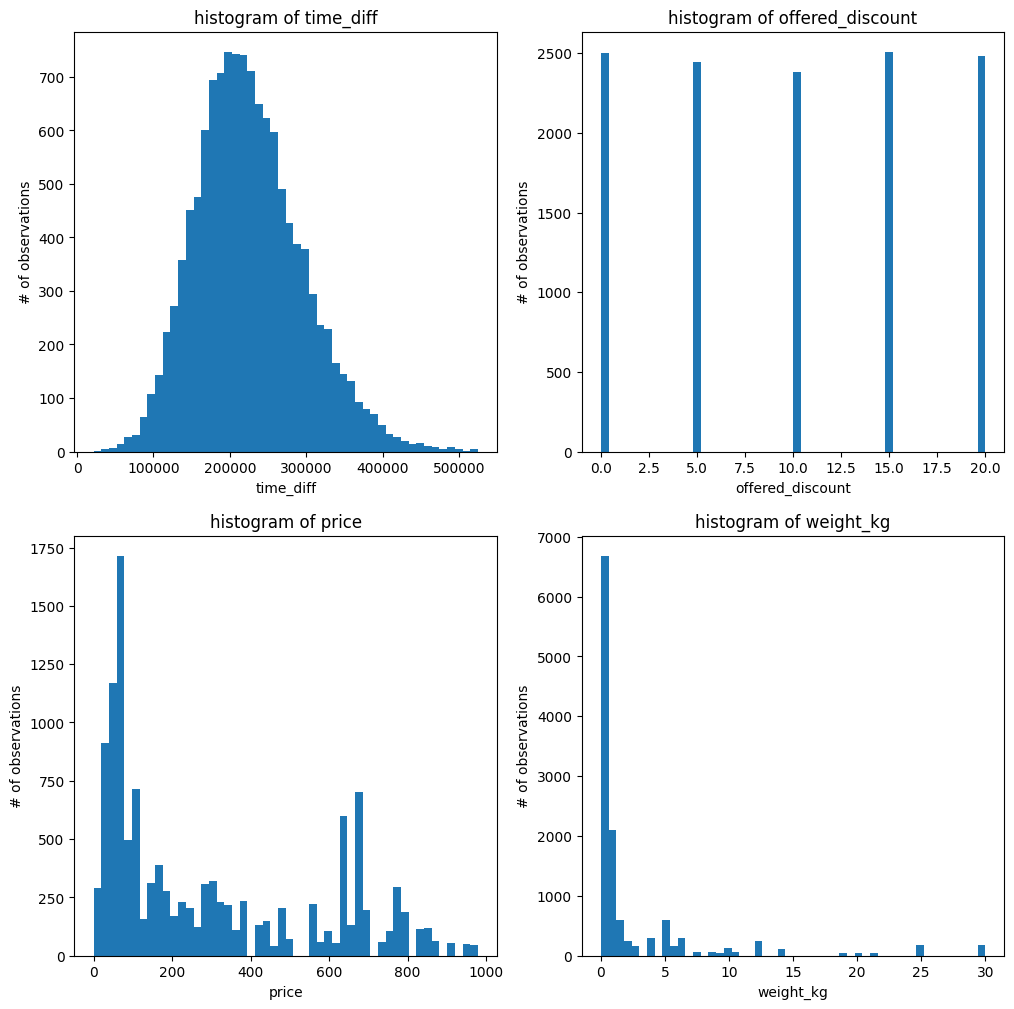

In [28]:
if MAKE_PLOTS:
    plot_histograms(df)

### without time_diff below 0

In [29]:
df_with_time_diff_below_0 = df
df = df[df["time_diff"] >= 0]

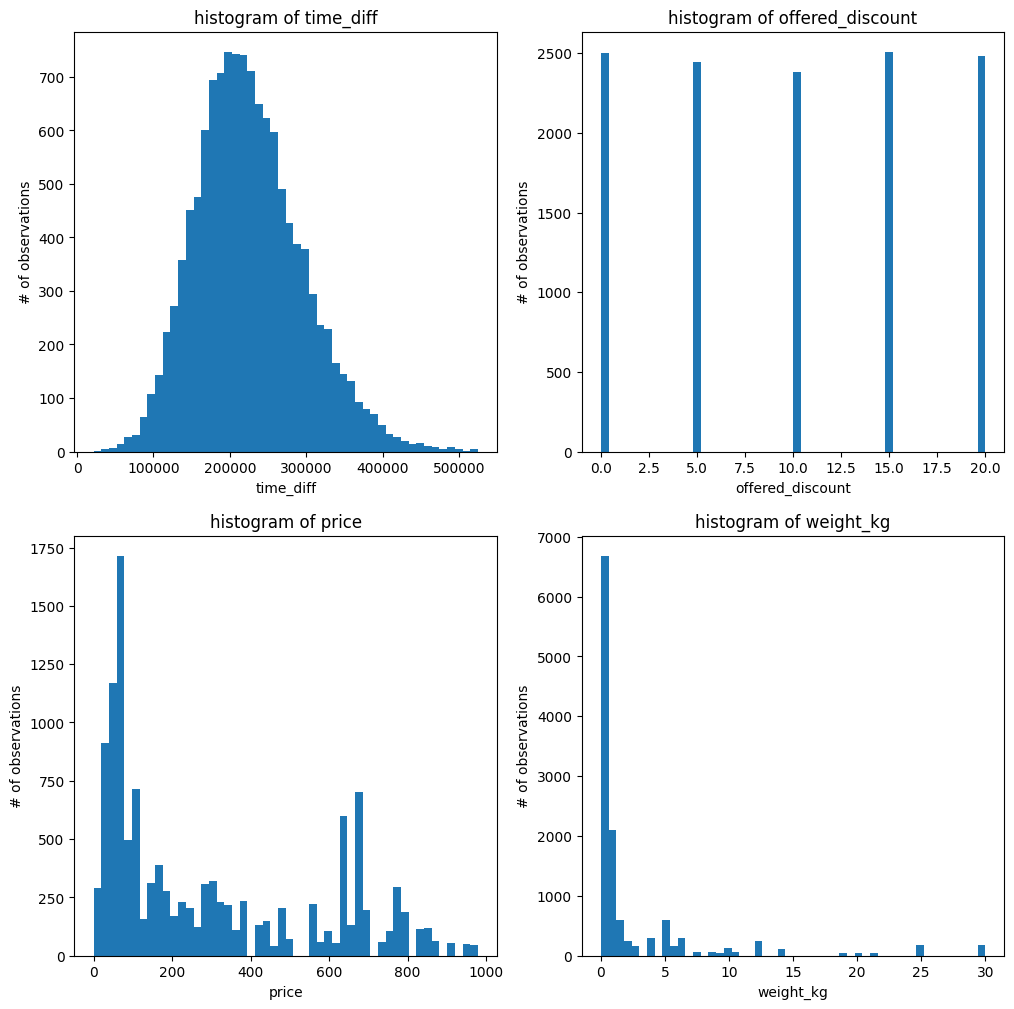

In [30]:
if MAKE_PLOTS:
    plot_histograms(df)

## heatmap

### with time_diff below zero

In [31]:
def update_list_of_columns():
    banned_list_of_columns = ["purchase_id", "delivery_company", "session_id", "user_id", "product_id"]
    columns_list = [col for col in df.columns.values.tolist() if col not in banned_list_of_columns]
    return columns_list

columns_list = update_list_of_columns()

(12320, 19)


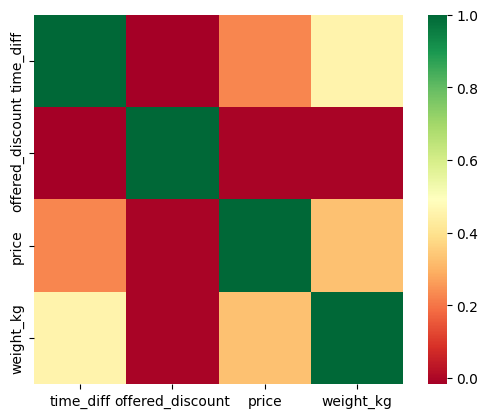

In [32]:
if MAKE_PLOTS:
    print(df_with_time_diff_below_0.shape)
    ax = sns.heatmap(df_with_time_diff_below_0[columns_list].corr(), square=True, cmap='RdYlGn')

### without time_diff below zero

#### pearson

(12320, 19)


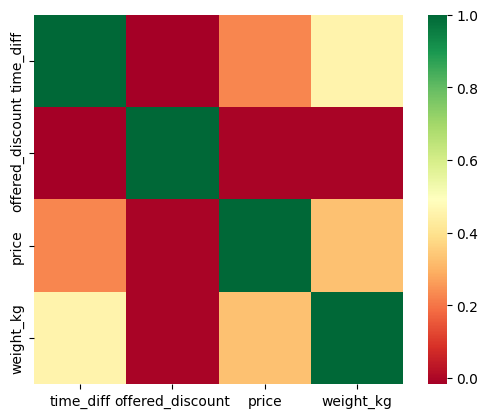

In [33]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('pearson'), square=True, cmap='RdYlGn')

#### spearman

(12320, 19)


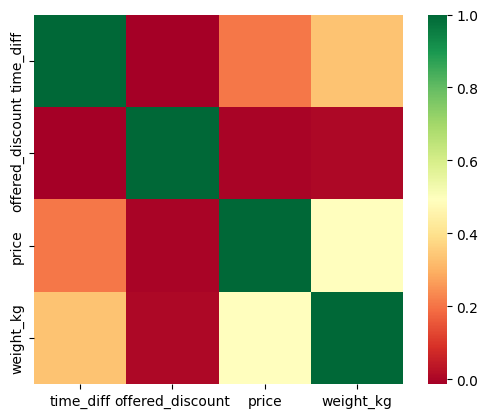

In [34]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('spearman'), square=True, cmap='RdYlGn')

#### kendall

In [35]:
# if MAKE_PLOTS:
#     print(df.shape)
#     ax = sns.heatmap(df[columns_list].corr('kendall'), square=True, cmap='RdYlGn')

## Pairplot

In [36]:
df.isnull().values.any()

False

In [37]:
df_temp = df.drop(columns='optional_attributes')
df_temp.nunique().sort_values()

event_type                1
delivery_company          3
offered_discount          5
city                      7
category_path            23
brand                    57
weight_kg               111
price                   143
product_id              162
product_name            162
name                    398
street                  398
user_id                 398
time_diff             12003
delivery_timestamp    12315
purchase_timestamp    12318
session_id            12320
purchase_id           12320
dtype: int64

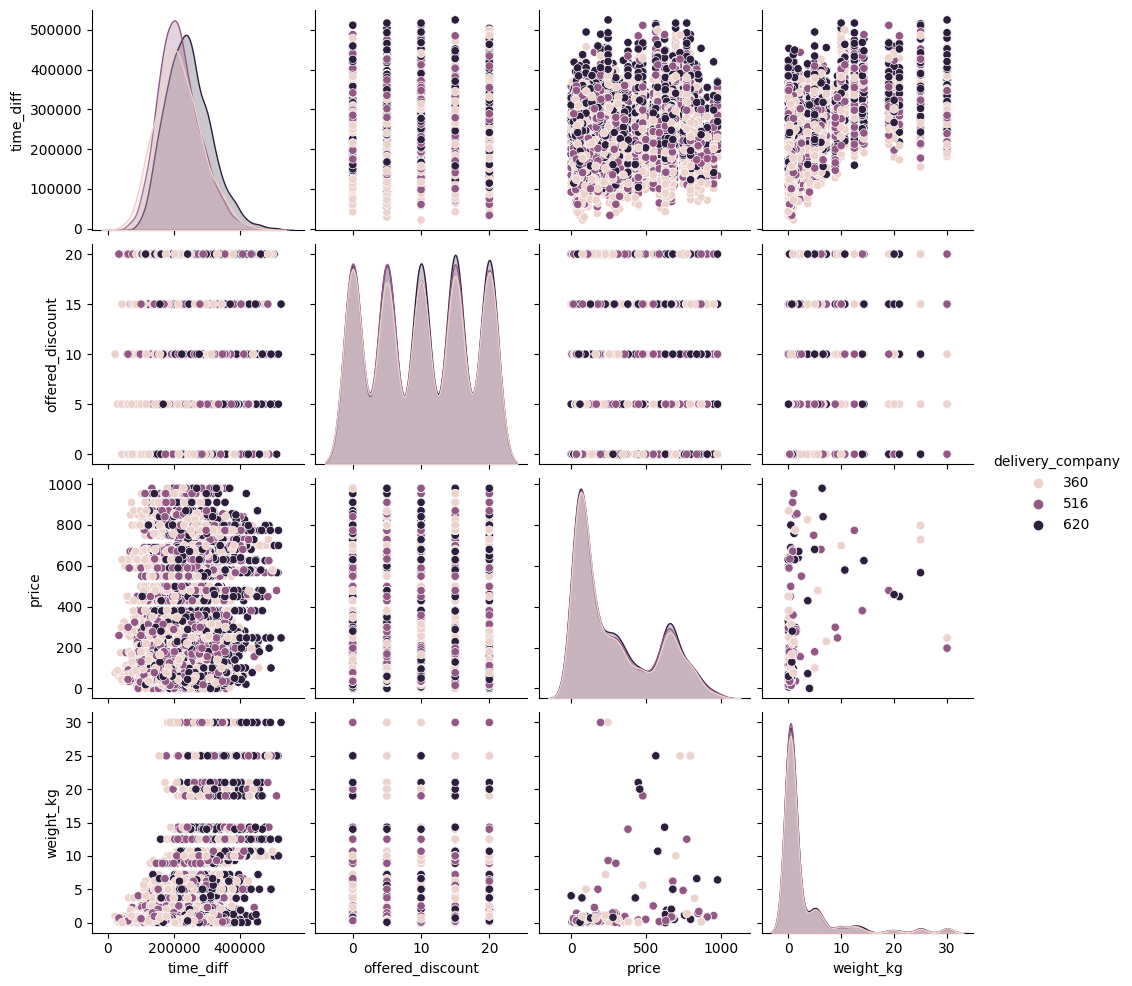

In [38]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='scatter', hue='delivery_company')

At first glance, the `delivery_company` attribute doesn't matter that much - more differentiation was expected.

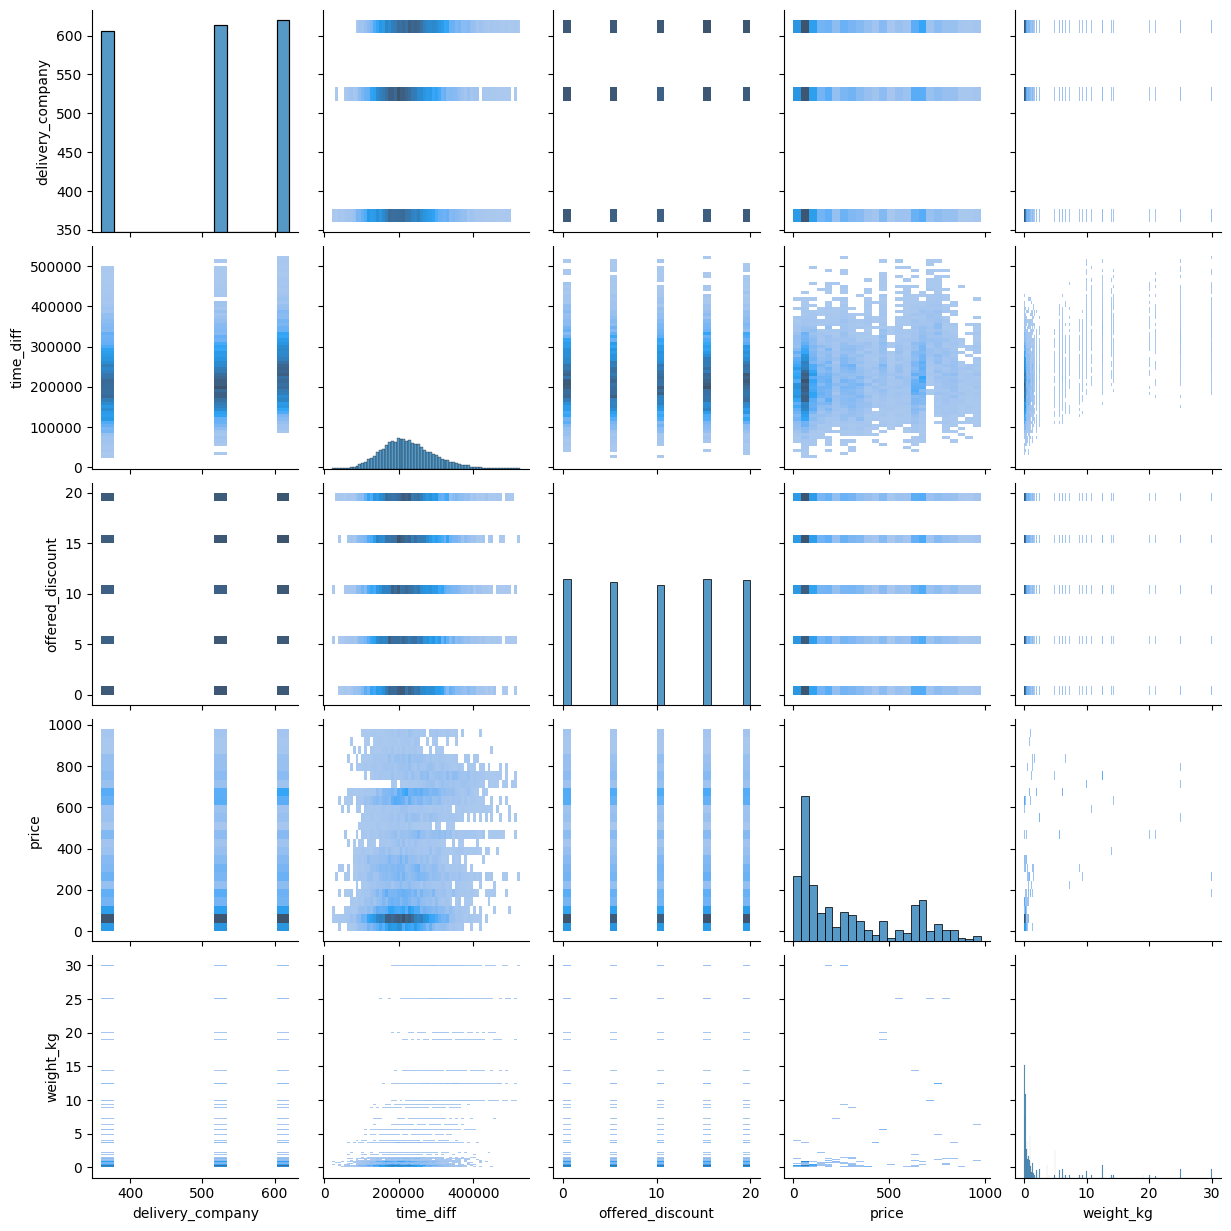

In [39]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='hist')

## visualizing time series

(array([1835., 1720., 1625., 1482., 1292., 1145.,  945.,  763.,  500.,
        1013.]),
 array([ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.]),
 <BarContainer object of 10 artists>)

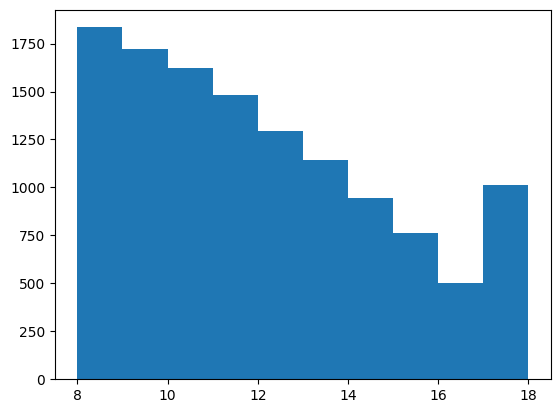

In [40]:
plt.hist(df['delivery_timestamp'].dt.hour)

In [41]:
df['purchase_timestamp'].nunique()

12318

In [42]:
time_series_df = df.copy()
time_series_df['purchase_date'] = time_series_df['purchase_timestamp'].dt.date
time_series_df = time_series_df.groupby(['purchase_date']).mean()
time_series_df.index = pd.to_datetime(time_series_df.index)
# time_series_df = time_series_df.reset_index()
# time_series_df['purchase_date'].nunique()
print(time_series_df.index.nunique())
display(time_series_df.head())
display(time_series_df.tail())

366


,purchase_id,delivery_company,time_diff,session_id,user_id,product_id,offered_discount,price,weight_kg
purchase_date,,,,,,,,,
2021-05-23,26329.800000,495.200000,200913.600000,10681.050000,299.050000,1172.800000,10.000000,260.795000,3.489150
2021-05-24,26247.729730,483.675676,210787.486486,10544.351351,296.729730,1204.675676,9.189189,251.982432,2.150324
2021-05-25,27116.230769,501.333333,204409.615385,12000.128205,324.102564,1209.820513,10.384615,321.956667,1.739385
2021-05-26,26412.583333,513.111111,203238.111111,10818.611111,301.750000,1224.805556,8.472222,244.382500,0.954806
2021-05-27,26264.416667,471.222222,253754.916667,10564.777778,297.083333,1225.611111,9.861111,312.664722,3.412222


,purchase_id,delivery_company,time_diff,session_id,user_id,product_id,offered_discount,price,weight_kg
purchase_date,,,,,,,,,
2022-05-19,25769.724138,494.482759,258683.275862,9747.241379,279.965517,1156.275862,8.620690,356.946552,2.431690
2022-05-20,25961.828571,453.600000,252582.171429,10065.971429,287.228571,1189.228571,9.571429,303.234857,1.881829
2022-05-21,26396.413793,467.586207,212049.103448,10794.620690,300.275862,1255.137931,9.655172,354.147241,0.954034
2022-05-22,26218.235294,500.705882,218451.911765,10486.970588,295.735294,1183.941176,8.823529,337.659118,1.645824
2022-05-23,26389.172414,499.862069,215454.896552,10783.310345,300.586207,1155.379310,9.310345,238.540000,3.010517


### 1. trend analysis - moving average

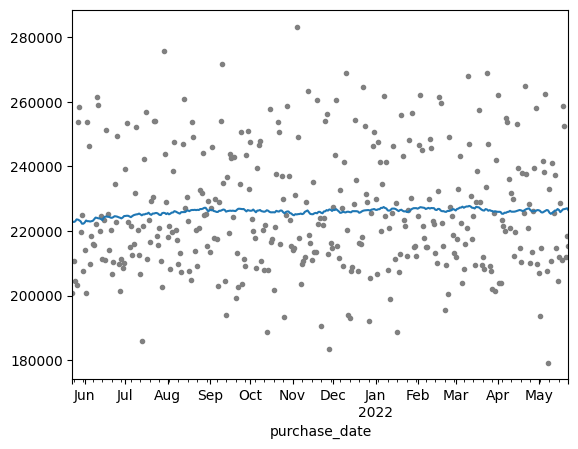

In [43]:
if MAKE_PLOTS:
    moving_average = time_series_df['time_diff'].rolling(
        window=90,
        center=True,
        min_periods=45
    ).mean()
    
    fig, ax = plt.subplots()
    ax.scatter(time_series_df.index, time_series_df['time_diff'], marker='.', color='0.5')
    moving_average.plot(ax=ax)
    plt.show()

It can be said that the trend is more or less constant.

### 2. time dependence (seasonality) analysis

#### weekly seasonality with indicators

##### function

In [44]:
# source: https://www.kaggle.com/code/ryanholbrook/seasonality

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

##### weekly seasonality plot

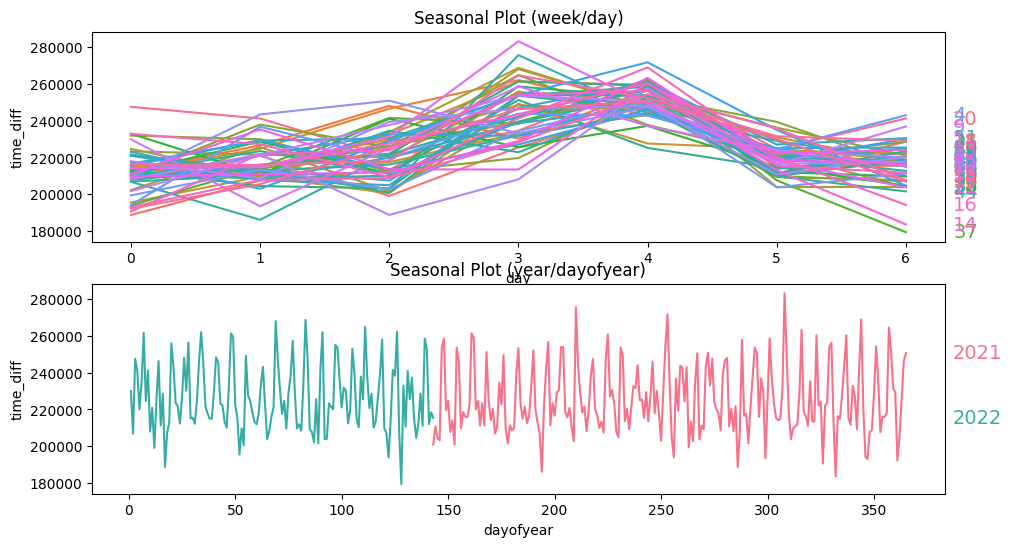

In [45]:
X = time_series_df.copy()

X["day"] = X.index.dayofweek
X["week"] = X.index.week

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

if MAKE_PLOTS:
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
    seasonal_plot(X, y="time_diff", period="week", freq="day", ax=ax0)
    seasonal_plot(X, y="time_diff", period="year", freq="dayofyear", ax=ax1)

Above, we can see that the day of the week matters - for example, from the fourth to the fifth day of the week we almost always see a significant decrease in average delivery time.

On the other hand, in the graph showing the annual period, it is hard to find any correlations.

The detected seasonality over the week will be taken into account in the model with the help of indicators through one-hot encoding.

It is worth mentioning that in the chart above you can see that the average value of `time_diff` for consecutive days jumps up and down a lot. Perhaps there are some cycles there that can be detected in the next section.

In [46]:
df['day_of_week'] = df['purchase_timestamp'].dt.dayofweek

#### periodogram - seasonality with fourier features

##### function

In [47]:
# source: https://www.kaggle.com/code/ryanholbrook/seasonality

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

##### periodogram plot

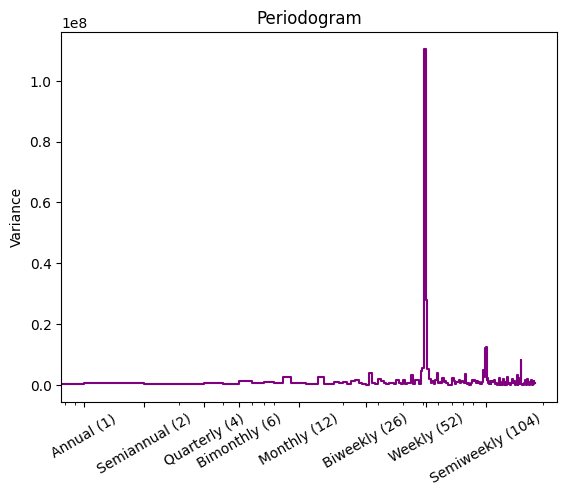

In [48]:
if MAKE_PLOTS:
    plot_periodogram(time_series_df["time_diff"])

In line with previous observations, we see a strong weekly dependence in the chart above. We can also see the lack of strong dependencies for longer periods - such as a month or a year.

However, it is not certain that this will be used in the final model. Perhaps it would require an additional model that predicts the average delivery time of a given day. Besides, the weekly dependency is likely to be correlated with what day of the week it is (previous point), which will be used in the model.

### 3. serial dependence (cycles) analysis

#### function

In [49]:
# source: https://www.kaggle.com/code/ryanholbrook/time-series-as-features

from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

#### lags comparison and autocorrelation

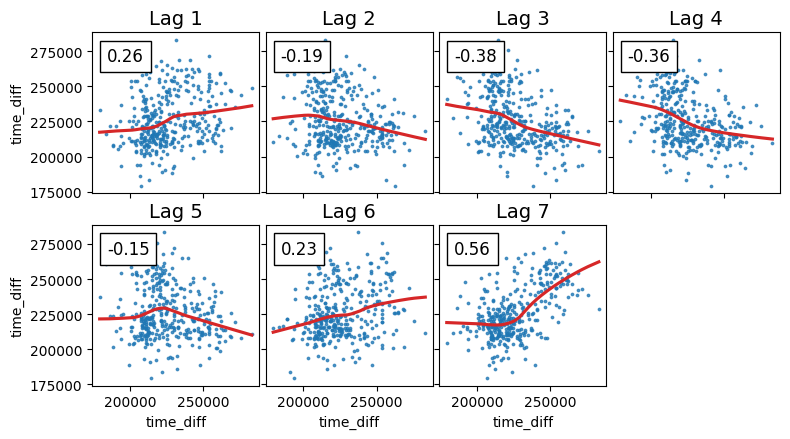

In [50]:
if MAKE_PLOTS:
    fig = plot_lags(time_series_df["time_diff"], lags=7, nrows=2)

#### partial autocorrelation

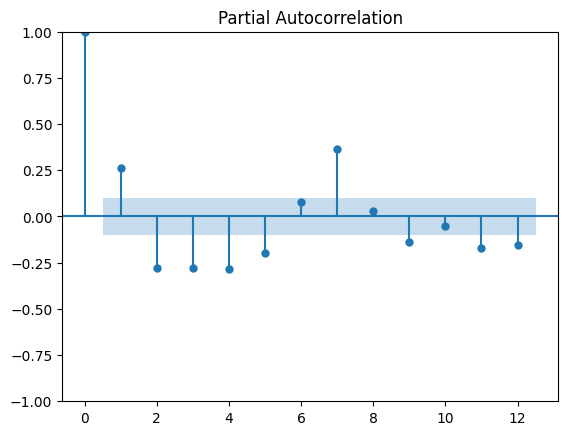

In [51]:
if MAKE_PLOTS:
    fig = plot_pacf(time_series_df["time_diff"], lags=12)

We have to remember that these are correlations with the average delivery time for a given day. This correlation would have to indirectly impact the prediction of delivery time for a particular order.

Eventually from all the time series analysis above, we will limit ourselves to adding an attribute with information about the day of the week.

In [52]:
# lag = 119
# display(time_series_df.time_diff.iloc[5:10])
# display(time_series_df.time_diff.iloc[0+lag:5+lag])

# feature engineering

In [53]:
cols_to_drop_after_feature_engineering = set()

## interactions

### city and street

In [54]:
df['city_and_street'] = df['city'] + ' ' + df['street']
display(df[['city_and_street', 'city', 'street']])

,city_and_street,city,street
0,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
1,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
2,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
3,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
4,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
...,...,...,...
12423,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12424,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12425,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12426,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88


## purchase timestamp

In [55]:

df['purchase_datetime_delta'] = (df['purchase_timestamp'] - df['purchase_timestamp'].min())  / np.timedelta64(1,'D')

## mutual information

In [56]:
feature_eng_df = df.copy()
feature_eng_df = feature_eng_df.infer_objects()
feature_eng_df = feature_eng_df.set_index('purchase_timestamp').sort_index()
feature_eng_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12320 entries, 2021-05-23 14:05:51 to 2022-05-23 19:22:00
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   purchase_id              12320 non-null  int64         
 1   delivery_timestamp       12320 non-null  datetime64[ns]
 2   delivery_company         12320 non-null  int64         
 3   time_diff                12320 non-null  float64       
 4   session_id               12320 non-null  int64         
 5   user_id                  12320 non-null  int64         
 6   product_id               12320 non-null  int64         
 7   event_type               12320 non-null  object        
 8   offered_discount         12320 non-null  int64         
 9   name                     12320 non-null  object        
 10  city                     12320 non-null  object        
 11  street                   12320 non-null  object        
 1

In [57]:
cols_to_drop_feature_eng = ['delivery_timestamp',
                            'event_type',
                            'optional_attributes',
                            'purchase_id',
                            'session_id',
                            'user_id',
                            'product_id']
feature_eng_df = feature_eng_df.drop(columns=cols_to_drop_feature_eng)

In [58]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

BIN_SIZE = 2

def make_mi_scores(in_df, y, reg_version=True, bin_size=BIN_SIZE):
    X = in_df.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    if reg_version:
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0, n_neighbors=bin_size)
    else:
        mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0, n_neighbors=bin_size)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def create_mi_plot(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def plot_mi_for_col(in_df, col_name='time_diff', reg_version=True):
    X = in_df.copy()
    y = X.pop(col_name)
    mi_scores = make_mi_scores(X, y, reg_version)
    create_mi_plot(mi_scores)

In [59]:
mi_score_df = feature_eng_df.copy()

# NOTE 1:
# these columns give errors in mutual_info_regression
# changing their type to float makes them seen as continuous instead of discrete
# mi_score_df['purchase_id'] = mi_score_df['purchase_id'].astype(float)
# mi_score_df['session_id'] = mi_score_df['session_id'].astype(float)

# NOTE 2:
# these columns have been eventually dropped

### for target (time diff)

In [60]:
def get_mi_for_bin_size(in_df, col_name='time_diff', reg_version=True, bin_size=3):
    X = in_df.copy()
    y = X.pop(col_name)
    mi_scores = make_mi_scores(X, y, reg_version, bin_size)
    return mi_scores

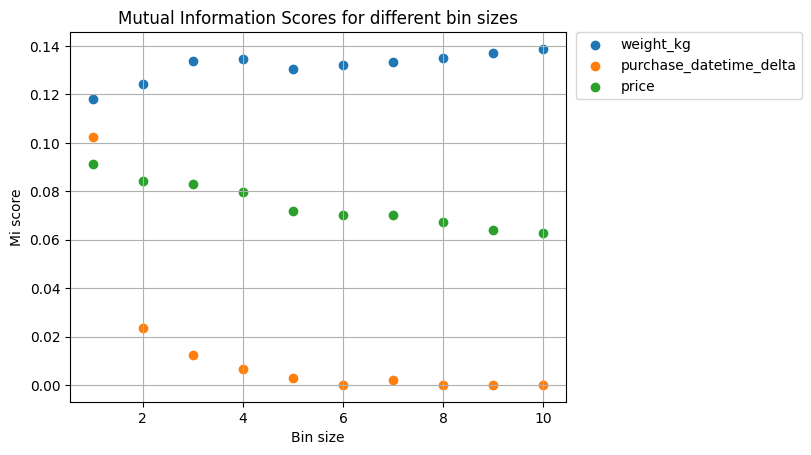

In [61]:
# find best bin_size for weight_kg column
bin_sizes = np.linspace(1, 10, 10).astype(int)
mi_bin_df = pd.DataFrame()
for size in bin_sizes:
    mi_scores = get_mi_for_bin_size(mi_score_df[['weight_kg', 'price', 'purchase_datetime_delta', 'time_diff']], bin_size=size)
    mi_bin_df = mi_bin_df.append(mi_scores)

fig, ax = plt.subplots()
for col_num in range(len(mi_bin_df.columns)):
    ax.scatter(bin_sizes, mi_bin_df.iloc[:, col_num], label=mi_bin_df.columns[col_num])
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_title('Mutual Information Scores for different bin sizes')
ax.set_xlabel('Bin size')
ax.set_ylabel('Mi score')
ax.grid(True)

Based on the above chart, bin size will be set to 2.

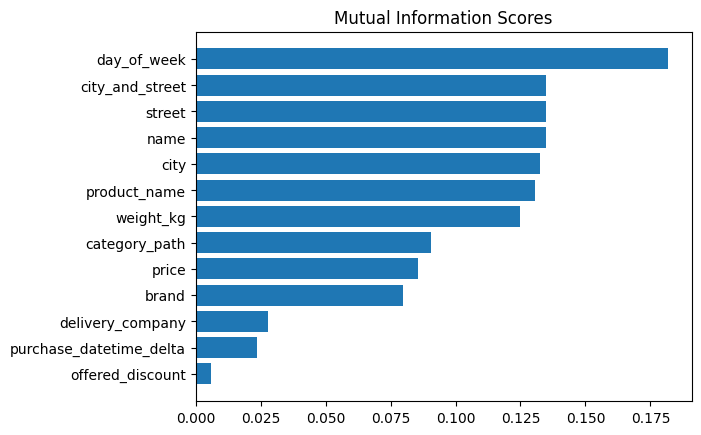

In [62]:
if MAKE_PLOTS:
    plot_mi_for_col(mi_score_df, 'time_diff')

- `street`, `name` and `user_id` are probably redundant and you only need to select one of these attributes. This will be confirmed in the next section.
- `city` is an important attribute, as can also be seen in the charts below
- `product_name`, `product_id` and `weight_kg` are probably redundant. This will be checked further on.
- `weight_kg` will certainly be taken into account because of the linear correlation detected in previous sections.
- decisions on the other attributes will be made later

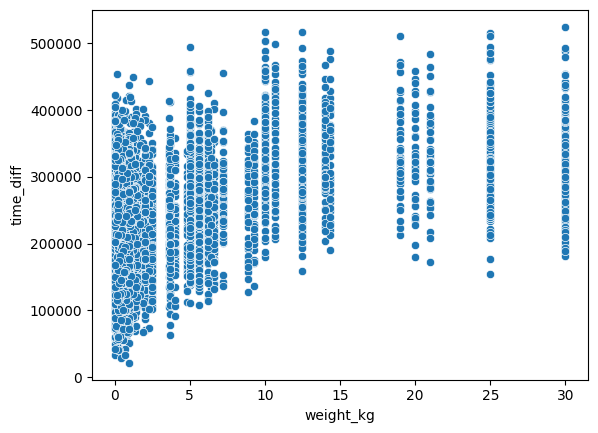

In [63]:
if MAKE_PLOTS:
    g = sns.scatterplot(x='weight_kg', y='time_diff', data=df)

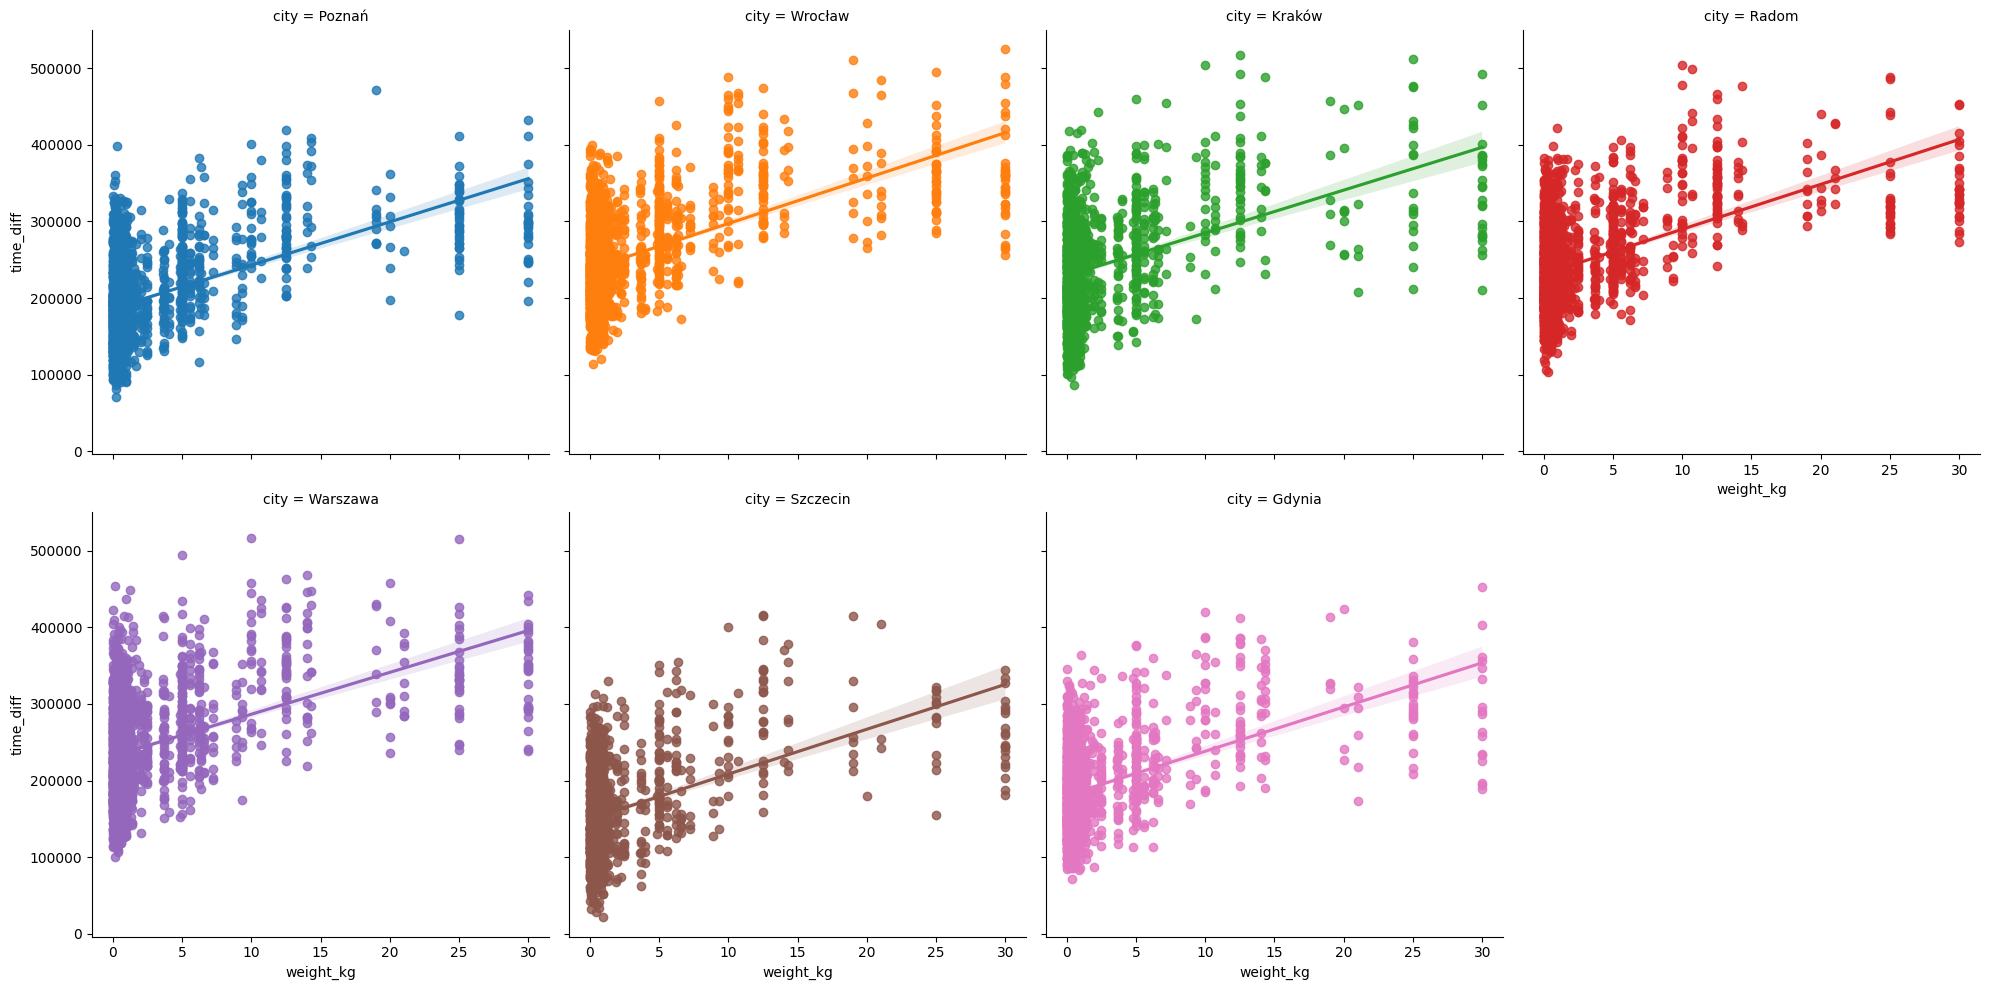

In [64]:
if MAKE_PLOTS:
    g = sns.lmplot(x='weight_kg', y='time_diff', col='city', hue='city', col_wrap=4, data=df)

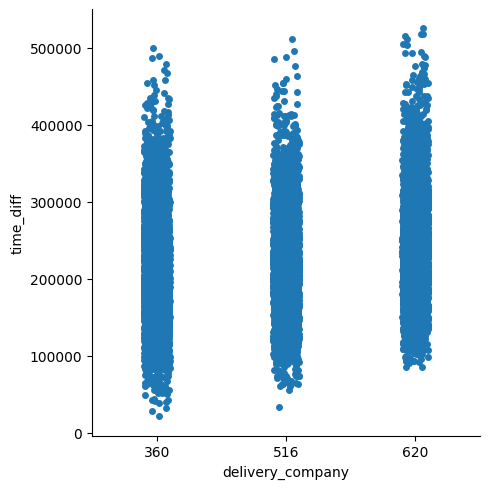

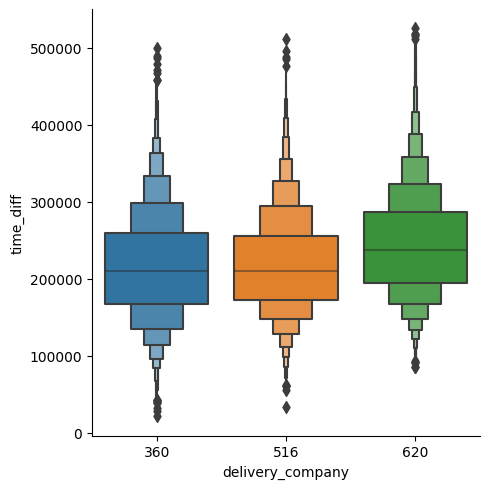

In [65]:
if MAKE_PLOTS:
    sns.catplot(x='delivery_company', y='time_diff', data=df)
    sns.catplot(x='delivery_company', y='time_diff', data=df, kind='boxen')

### for street

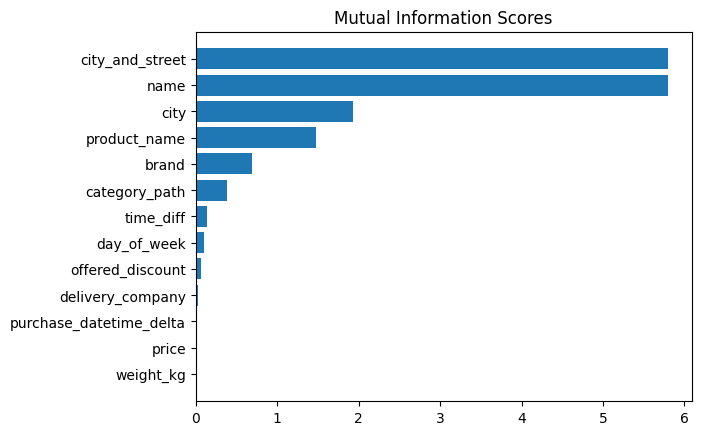

In [66]:
if MAKE_PLOTS:
    plot_mi_for_col(mi_score_df, 'street', reg_version=False)

We can see that for `street` attributes `name`, and `user_id` are reduntant. Of these three attributes, `street` will be chosen because it will still carry important information in the event of a relocation, while `user_name` or `user_id` will remain the same and may cause the model to perform worse.

In addition to this, the `session_id` and `purchase_id` columns will also be immediately added to the list of attributes to be discarded - these are just identifiers that are generated for each new order and there are no dependencies involved.

In [67]:
cols_to_drop_after_feature_engineering.update(['name', 'user_id', 'session_id', 'purchase_id'])
mi_score_df = mi_score_df.drop(columns=list(cols_to_drop_after_feature_engineering), errors='ignore')

### for product_name

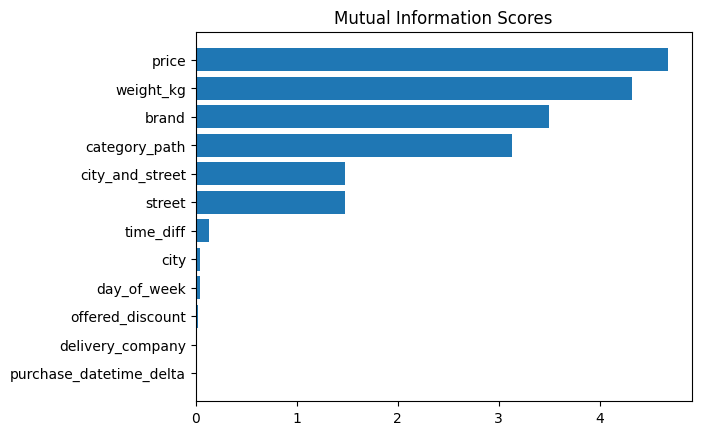

In [68]:
if MAKE_PLOTS:
    plot_mi_for_col(mi_score_df, 'product_name', reg_version=False)

Here, `product_id` will be selected and `product_name` will be dropped.

In [69]:
cols_to_drop_after_feature_engineering.update(['product_name'])
mi_score_df = mi_score_df.drop(columns='product_name')

# dropping columns (choosing attributes)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12320 entries, 0 to 12427
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   purchase_id              12320 non-null  int64         
 1   purchase_timestamp       12320 non-null  datetime64[ns]
 2   delivery_timestamp       12320 non-null  datetime64[ns]
 3   delivery_company         12320 non-null  int64         
 4   time_diff                12320 non-null  float64       
 5   session_id               12320 non-null  int64         
 6   user_id                  12320 non-null  int64         
 7   product_id               12320 non-null  int64         
 8   event_type               12320 non-null  object        
 9   offered_discount         12320 non-null  int64         
 10  name                     12320 non-null  object        
 11  city                     12320 non-null  object        
 12  street                   12320 n

In addition to the columns defined for rejection in the feature engineering section, we also drop:
1. `delivery_timestamp`, because otherwise we would have data leakage (information from the future would allow the model to accurately predict the delivery time)
2. `event_type`, because this column contains only one value

In [71]:
# from src.TimeDiffConstants import COLS_TO_DROP_ALWAYS
COLS_TO_DROP_ALWAYS = process_config.drop_columns
# drop columns
ADDITIONAL_COLUMNS_TO_DROP = COLS_TO_DROP_ALWAYS
df = df.drop(columns=ADDITIONAL_COLUMNS_TO_DROP)
df = df.drop(columns=["city_and_street", "brand", 'product_name'])

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12320 entries, 0 to 12427
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   delivery_company         12320 non-null  int64  
 1   time_diff                12320 non-null  float64
 2   product_id               12320 non-null  int64  
 3   city                     12320 non-null  object 
 4   street                   12320 non-null  object 
 5   category_path            12320 non-null  object 
 6   price                    12320 non-null  float64
 7   weight_kg                12320 non-null  float64
 8   day_of_week              12320 non-null  int64  
 9   purchase_datetime_delta  12320 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 1.0+ MB


# one-hot encoding

In [73]:
# df.to_excel("data_before_one_hot_encoding.xlsx")

In [74]:
def one_hot_encode_a_col_in_pd(df, col_name):
    one_hot = pd.get_dummies(df[col_name], drop_first=False)
    df = df.drop(columns=col_name)
    df = df.join(one_hot)
    return df

In [75]:
COLUMNS_TO_ONE_HOT = ["delivery_company", "city", "category_path", "street", 'day_of_week', 'product_id']

for col_name in COLUMNS_TO_ONE_HOT:
    df = one_hot_encode_a_col_in_pd(df, col_name)

#### checking df shape

In [76]:
print(df.shape)
columns_list = update_list_of_columns()
# ax = sns.heatmap(df[columns_list].corr(), square=True, cmap='RdYlGn')

(12320, 604)


In [77]:
df = df.dropna()
print(df.shape)
# one-hot encoding took care of missing data, so shape has not changed

(12320, 604)


In [78]:
df.columns = df.columns.astype(str)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12320 entries, 0 to 12427
Columns: 604 entries, time_diff to 1617
dtypes: float64(4), uint8(600)
memory usage: 7.8 MB


# normalization

In [80]:
# specify columns for standardization scaling (Z-score normalization)
cols_to_std = []

# specify columns for min-max scaling
# offered_discount, price, weight_kg, purchase_datetime_delta
cols_to_min_max = ['price', 'weight_kg', 'purchase_datetime_delta']
# cols_to_min_max = ['weight_kg']

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for col in cols_to_std:
    x = df[col].values
    std_scaler = StandardScaler()
    x_scaled = std_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

for col in cols_to_min_max:
    x = df[col].values
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

# test of linear regression models

In [82]:
df.head()

,time_diff,price,weight_kg,purchase_datetime_delta,360,516,620,Gdynia,Kraków,Poznań,...,1464,1475,1487,1535,1547,1558,1562,1588,1597,1617
0,179997.0,0.162411,0.017333,0.459102,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,169885.0,0.043912,0.000500,0.191164,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,164705.0,0.643248,0.000000,0.082217,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,220485.0,0.284985,0.019667,0.822567,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,138672.0,0.044934,0.008667,0.343056,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_data(df, target_column="time_diff"):
    y = df["time_diff"].to_numpy()
    X = df.drop(columns="time_diff")
    return train_test_split(X, y, test_size=0.2, random_state=SEED)

In [84]:
def train_models(models_list, X_train, y_train):
    for model in models_list:
        model.fit(X_train, y_train)
    return models_list

In [85]:
def create_df_with_predictions(models_list, X_test, y_test):
    y_pred_df = pd.DataFrame()
    y_pred_df["y_test"] = y_test
    for model in models_list:
        y_pred_df[f"{type(model).__name__} prediction"] = model.predict(X_test)
    return y_pred_df

In [86]:
def display_predictions(y_pred_df):
    display(y_pred_df.head())
    display(y_pred_df.info())
    display(y_pred_df.describe())

In [87]:
def print_scores(models_list, X_test, y_test):
    for model in models_list:
        score = model.score(X_test, y_test)
        print(f"{type(model).__name__} score = {score}")

In [88]:
def print_percent_of_good_predictions(models_list, X_test, y_test, error=NUM_OF_HOURS*60*60):
    for model in models_list:
        predictions = model.predict(X_test)
        predictions_time_diff = np.abs(y_test - predictions)
        num_of_good_predictions = (predictions_time_diff < error).sum()
        percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
        print(f'number of good predictions for {type(model).__name__} = {num_of_good_predictions}')
        print(f'which is {percent_of_good_predictions * 100}%')

In [89]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = split_data(df)

models_list = [Ridge(alpha=0.1),
               Lasso(alpha=0.1),
               DecisionTreeRegressor(random_state=SEED),
               RandomForestRegressor(random_state=SEED)]
models_list = train_models(models_list, X_train, y_train)

y_pred_df = create_df_with_predictions(models_list, X_test, y_test)
# display_predictions(y_pred_df)

print_scores(models_list, X_test, y_test)

print_percent_of_good_predictions(models_list, X_test, y_test)

Ridge score = 0.4534372960937204
Lasso score = 0.45297125375246583
DecisionTreeRegressor score = 0.2266203446314511
RandomForestRegressor score = 0.5099115186120233
number of good predictions for Ridge = 2241
which is 90.94967532467533%
number of good predictions for Lasso = 2240
which is 90.9090909090909%
number of good predictions for DecisionTreeRegressor = 2145
which is 87.05357142857143%
number of good predictions for RandomForestRegressor = 2282
which is 92.61363636363636%


In [90]:
print_percent_of_good_predictions(models_list, X_test, y_test, error=NUM_OF_HOURS/2*60*60)

number of good predictions for Ridge = 1527
which is 61.9724025974026%
number of good predictions for Lasso = 1527
which is 61.9724025974026%
number of good predictions for DecisionTreeRegressor = 1476
which is 59.9025974025974%
number of good predictions for RandomForestRegressor = 1701
which is 69.0340909090909%
